# 1. Setup Asyncio

In [1]:
import nest_asyncio

nest_asyncio.apply()

# 2. Setup the Qdrant vector database

In [2]:
import qdrant_client

collection_name = "chat_with_docs_docling"

client = qdrant_client.QdrantClient(
    host="localhost",
    port=6333,
)

/Users/fc/experiments/rag-project/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# 3. Read the documents

Convert to markdown using Docling

In [14]:
import os
from glob import glob
from pathlib import Path

from docling.datamodel.base_models import InputFormat
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.pipeline_options import PdfPipelineOptions, TableFormerMode
from docling_core.types.doc import ImageRefMode, PictureItem, TableItem



pdf_dir = "./docs"
pdf_files = glob(os.path.join(pdf_dir, "docling.pdf")) # TODO: Restore to *.pdf
md_files = []

IMAGE_RESOLUTION_SCALE = 2.0
output_dir = Path("scratch")
output_dir.mkdir(parents=True, exist_ok=True)

# Pipeline options for PDF conversion
pipeline_options = PdfPipelineOptions(do_table_structure=True)
# Table options
pipeline_options.table_structure_options.mode = TableFormerMode.ACCURATE  # use more accurate TableFormer model
# Image options
pipeline_options.images_scale = IMAGE_RESOLUTION_SCALE
pipeline_options.generate_picture_images = True
pipeline_options.generate_page_images = True        # This is needed to generate table images

converter = DocumentConverter(
    format_options={
        InputFormat.PDF: PdfFormatOption(pipeline_options=pipeline_options)
    }
)

# Convert each PDF to Markdown using Docling's Python API
ddocs = []
for pdf_path in pdf_files:
    result = converter.convert(pdf_path)
    ddocs.append(result.document)

    # Save images of figures and tables
    doc_filename = result.input.file.stem
    # table_counter = 0
    picture_counter = 0
    for element, _level in result.document.iterate_items():
        if isinstance(element, TableItem):
            table_counter += 1
            element_image_filename = (
                output_dir / f"{doc_filename}-table-{table_counter}.png"
            )
            with element_image_filename.open("wb") as fp:
                element.get_image(result.document).save(fp, "PNG")

        if isinstance(element, PictureItem):
            picture_counter += 1
            element_image_filename = (
                output_dir / f"{doc_filename}-picture-{picture_counter}.png"
            )
            with element_image_filename.open("wb") as fp:
                element.get_image(result.document).save(fp, "PNG")

    # Save markdown with externally referenced pictures
    md_filename = output_dir / f"{doc_filename}-with-image-refs.md"
    result.document.save_as_markdown(md_filename, image_mode=ImageRefMode.REFERENCED)

/Users/fc/experiments/rag-project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/fc/experiments/rag-project/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


## Inspecting Docling Documents

[PictureItem(self_ref='#/pictures/0', parent=RefItem(cref='#/body'), children=[], content_layer=<ContentLayer.BODY: 'body'>, label=<DocItemLabel.PICTURE: 'picture'>, prov=[ProvenanceItem(page_no=1, bbox=BoundingBox(l=261.96795654296875, t=715.9161758422852, r=348.657958984375, b=627.1296234130859, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 0))], captions=[], references=[], footnotes=[], image=ImageRef(mimetype='image/png', dpi=144, size=Size(width=173.0, height=178.0), uri=AnyUrl('')), annotations=[]),
 PictureItem(self_ref='#/pictures/1', parent=RefItem(cref='#/body'), children=[RefItem(cref='#/texts/31'), RefItem(cref='#/texts/32'), RefItem(cref='#/texts/33'), RefItem(cref='#/texts/34'), RefItem(cref='#/texts/35'), RefItem(cref='#/texts/36'), RefItem(cref='#/texts/37'), RefItem(cref='#/texts/38'), RefItem(cref='#/texts/39'), RefItem(cref='#/texts/40'), RefItem(cref='#/texts/41'), RefItem(cref='#/texts/42'), RefItem(cref='#/texts/43'), RefItem(cref='#/texts/44'
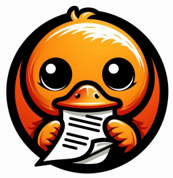
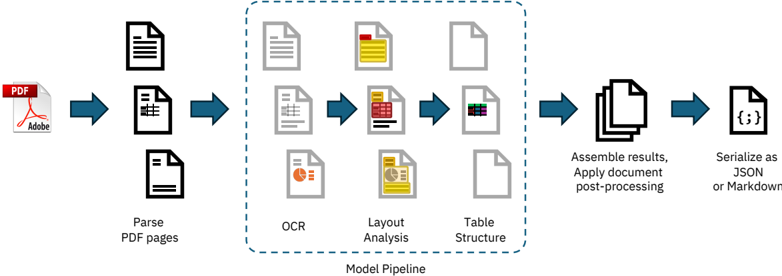
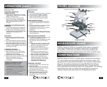
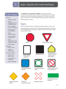
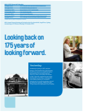
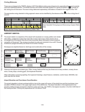
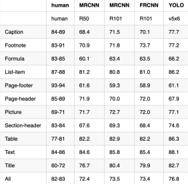
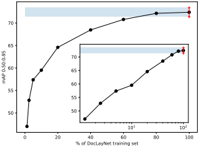
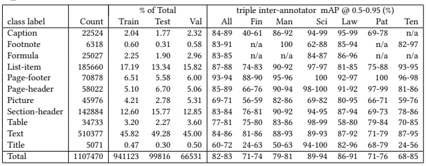
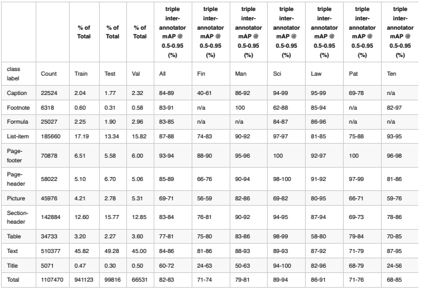
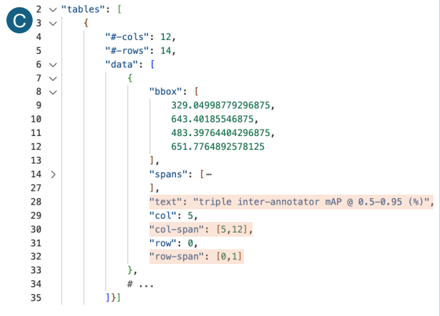

In [13]:
ddoc = ddocs[0]  # Use the first document for indexing
ddoc.pictures

In [5]:
ddoc.origin.filename

'docling.pdf'

In [6]:
image = ddoc.pictures[1]
provenance = image.prov[0]
provenance

ProvenanceItem(page_no=3, bbox=BoundingBox(l=110.07231140136719, t=719.2913360595703, r=500.7577209472656, b=581.2926177978516, coord_origin=<CoordOrigin.BOTTOMLEFT: 'BOTTOMLEFT'>), charspan=(0, 0))

In [8]:
import fitz  # PyMuPDF

def save_image_from_provenance(pdf_path, provenance, output_path):
    """
    Extracts and saves an image from a PDF using provenance info.
    provenance should have 'page_ix' (0-based) and 'bbox' ([x0, y0, x1, y1])
    """
    page_ix = provenance.page_no-1  # Convert to 0-based index
    _bbox = provenance.bbox  # format: [x0, y0, x1, y1]
    bbox = [_bbox.l, _bbox.t, _bbox.r, _bbox.b]  # Ensure bbox is a list of floats

    doc = fitz.open(pdf_path)
    page = doc[page_ix]
    clip = fitz.Rect(*bbox)
    pix = page.get_pixmap(clip=clip)
    pix.save(output_path)
    doc.close()

# Example usage:
pdf_path = os.path.join(pdf_dir, ddoc.origin.filename)  # Path to the original PDF
output_path = os.path.join(pdf_dir, "picture.png")  # Output path for the extracted image
save_image_from_provenance(pdf_path, provenance, output_path)

FzErrorArgument: code=4: Invalid bandwriter header dimensions/setup

## Loading markdown files

In [ ]:
from llama_index.core import SimpleDirectoryReader

input_dir_path = "./docs"

loader = SimpleDirectoryReader(
    input_dir=input_dir_path,
    required_exts=[".md"],
    recursive=True
)

docs = loader.load_data()

In [ ]:
docs

In [ ]:
type(docs), len(docs)

In [ ]:
### Debug
#Check what's the content retrieved from the PDF file

for doc in docs:
    print(doc.get_content())
    print(doc.metadata)
    print("-----")

## 4. Use Chonkie to chunk the documents

In [ ]:
from chonkie import SemanticChunker
from llama_index.core.schema import Document
from llama_index.core import Settings
from llama_index.embeddings.huggingface import HuggingFaceEmbedding


semantic_chunker = SemanticChunker(
    embedding_model="BAAI/bge-large-en-v1.5",
    threshold=0.5,
    chunk_size=512,
    min_sentences=1
)

embed_model = HuggingFaceEmbedding(model_name="BAAI/bge-large-en-v1.5",
                                   trust_remote_code=True)

Settings.embed_model = embed_model

all_chunks = []
for doc in docs:
    chunks = semantic_chunker.chunk(doc.text)
    for chunk in chunks:
        # Use LlamaIndex's embedding model to embed the chunk text
        chunk_embedding = Settings.embed_model.get_text_embedding(chunk.text)
        all_chunks.append(
            Document(
                text=chunk.text,
                metadata=doc.metadata,
                embedding=chunk_embedding
            )
        )

In [ ]:
len(all_chunks)

In [ ]:
all_chunks[:10]

## 5. Create Ddrant Collection

In [ ]:
# import numpy as np
# from qdrant_client.models import VectorParams, Distance
# from qdrant_client.models import PointStruct


# # Create the collection if it doesn't exist
# client.recreate_collection(
#     collection_name=collection_name,
#     vectors_config=VectorParams(
#         size=np.array(all_chunks[0].embedding).shape[0],  # dimension of your embedding
#         distance=Distance.COSINE                # or Distance.DOT, Distance.EUCLID
#     )
# )

# points = []
# for i, chunk in enumerate(all_chunks):
#     if chunk.embedding is not None:
#         points.append(
#             PointStruct(
#                 id=i,
#                 vector=chunk.embedding,
#                 payload={"text": chunk.text}
#             )
#         )

# client.upsert(
#     collection_name=collection_name,
#     points=points
# )

# 5. Load the embedding model and index data

In [ ]:
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import VectorStoreIndex, StorageContext

def create_index(documents):

    vector_store = QdrantVectorStore(client=client,
                                     collection_name=collection_name)
    
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    
    index = VectorStoreIndex.from_documents(documents,
                                            storage_context=storage_context)
    
    return index

In [ ]:
from llama_index.core import Settings

index = create_index(all_chunks)

In [ ]:
type(index)

## 6. Load the LLM

In [ ]:
from llama_index.llms.ollama import Ollama
from llama_index.core import Settings


llm = Ollama(model="llama3.2:1b", request_timeout=120.0, temperature=0.0)

Settings.llm = llm

In [ ]:
type(Settings), Settings.llm, Settings.embed_model

# 7. Define the prompt template

In [ ]:
from llama_index.core import PromptTemplate

template = """Context information is below:
              ---------------------
              {context_str}
              ---------------------
              Given the context information above I want you to think
              step by step to answer the query in a crisp manner,
              incase you don't know the answer say 'I don't know!'
            
              Query: {query_str}
        
              Answer:"""

qa_prompt_tmpl = PromptTemplate(template)

In [ ]:
## 8. Query Qdrant directly with your own embedding


In [ ]:
# query = "What exactly is DSPy?"

# # Use the same embedding model as for chunking
# query_embedding = semantic_chunker.chunk([query])[0]

# search_result = client.search(
#     collection_name=collection_name,
#     query_vector=query_embedding.tolist(),
#     limit=5
# )

# # Gather the top results' texts
# top_chunks = [hit.payload["text"] for hit in search_result]

# # Optionally, synthesize an answer using your LLM
# context_str = "\n\n".join(top_chunks)
# prompt = template.format(context_str=context_str, query_str=query)

# response = llm.complete(prompt)
# print(response)

# 8. Reranking

Here, we use a cross-encoder to re-rank the document chunks. Also, we limit the output to the top 3 most relevant chunks based on the model’s scoring.

In [ ]:
from llama_index.core.postprocessor import SentenceTransformerRerank

rerank = SentenceTransformerRerank(
    model="cross-encoder/ms-marco-MiniLM-L-2-v2", 
    top_n=3
)

In [ ]:
rerank

# 9. Query the document

In [ ]:
query_engine = index.as_query_engine(similarity_top_k=10,
                                     node_postprocessors=[rerank])

query_engine.update_prompts(
    {"response_synthesizer:text_qa_template": qa_prompt_tmpl}
)

# response = query_engine.query("What exactly is DSPy?")
# response = query_engine.query("How is DSPy pronounced?")
# response = query_engine.query("What is the github repo for docling?")
response = query_engine.query("What is the TTS for docling with pypdfium backend, when running on an Apple M3 Max using 4 threads for the test dataset of 225 pages?")
# response = query_engine.query("Which is the RationalAI product that addresses customer care?")
# response = query_engine.query("What is the point with the Rational control room?")

In [ ]:
from IPython.display import Markdown, display

display(Markdown(str(response)))

In [ ]:
response.metadata

In [ ]:
response.response

## Debug

In [ ]:
docs[0].text

In [ ]:
from IPython.display import Markdown, display
import re

def highlight(text, query, color):
        # Case-insensitive highlight
        pattern = re.compile(re.escape(query), re.IGNORECASE)
        return pattern.sub(f"<mark style='background-color:{color};'>{query}</mark>", text)

def display_sources_with_highlight(response, docs, query, highlight_color="#ffff00"):
    """
    Display source documents for the response, highlighting the query in the text.
    """
    
    for source in response.metadata.values():
        source_document = source.get("file_name")
        source_page = source.get("page_label")
        if source_page:
            # We need also to filter per document file_name
            d = next((doc for doc in docs if doc.metadata.get("file_name") == source_document and doc.metadata.get("page_label") == source_page), None)
            if d:
                highlighted = highlight(d.text, query, highlight_color)
                display(Markdown(f"### Source Document (page_label: {source_page})\n\n{highlighted}"))

# Example usage:
word = "TTS"
display_sources_with_highlight(response, docs, word)

Let's try retrieving the docs containing the query instead

In [ ]:
# Write an inline function to find the first document containing a specific text
def find_document_with_text(text):
    for i, doc in enumerate(docs):
        if text in doc.text:
            return i, doc
    return None, None

i, doc = find_document_with_text(word)

In [ ]:
doc

In [ ]:
Markdown(highlight(doc.text, word, "#ffff00"))